In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from torchtext import data
from torchtext import datasets
import collections
import math

In [2]:
import re
import spacy

nlp = spacy.load('en')
MAX_CHARS = 20000
def tokenizer(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|;]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", "!", comment)
    comment = re.sub(r"\,+", ",", comment)
    comment = re.sub(r"\?+", "?", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [x.text for x in nlp.tokenizer(comment) if x.text != " "]

In [3]:
TEXT = data.Field(tokenize=tokenizer, include_lengths = True)
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = data.TabularDataset.splits(path='./', format='csv',train='train.csv', test='test.csv', fields=[('text', TEXT), ('label', LABEL)])

In [4]:
train_data, valid_data = train_data.split()

In [5]:
embedding = torchtext.vocab.Vectors('quora.300d.txt')

TEXT.build_vocab(train_data, 
                 vectors = embedding,
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

100%|█████████▉| 87287/87708 [00:09<00:00, 9158.07it/s]


In [7]:
BATCH_SIZE = 2048

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text))

In [15]:
device

device(type='cuda')

In [23]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def metrics(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    acc = accuracy_score(y.cpu(), rounded_preds.detach().cpu())
    f1 = f1_score(y.cpu(), rounded_preds.detach().cpu())
    return acc, f1

In [25]:
def train_rnn(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, f1 = metrics(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [26]:
def evaluate_rnn(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc, f1 = metrics(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [27]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

rnn = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors

rnn.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

rnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [28]:
import torch.optim as optim

optimizer = optim.Adam(rnn.parameters())

criterion = nn.BCEWithLogitsLoss()

rnn = rnn.to(device)
criterion = criterion.to(device)

In [29]:
N_EPOCHS = 10

best_valid_f1 = 0

for epoch in range(N_EPOCHS):
    
    train_loss, train_acc, train_f1 = train_rnn(rnn, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate_rnn(rnn, valid_iterator, criterion)
    
    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(rnn.state_dict(), 'LSTM-model.pt')
    
    print('Epoch:',epoch+1)
    print('Train Loss:',train_loss)
    print('Train Acc:',train_acc*100)
    print('Train F1:',train_f1*100)
    print('Val. Loss:',valid_loss) 
    print('Val. Acc:',valid_acc*100)
    print('Val. F1:',valid_f1*100)

Epoch: 1
Train Loss: 0.445600124862459
Train Acc: 78.9331377461322
Train F1: 72.67272712728216
Val. Loss: 0.3423773003251929
Val. Acc: 85.66043660287083
Val. F1: 83.68632253612837
Epoch: 2
Train Loss: 0.33532633980115256
Train Acc: 86.14731671940929
Train F1: 83.35259893776634
Val. Loss: 0.32182520314266805
Val. Acc: 87.84717564507861
Val. F1: 84.4434500683961
Epoch: 3
Train Loss: 0.2995005170504252
Train Acc: 88.00843607155416
Train F1: 85.3901824552268
Val. Loss: 0.2921530274968398
Val. Acc: 88.82428016062886
Val. F1: 86.93612390274623
Epoch: 4
Train Loss: 0.29149970014890036
Train Acc: 88.59223914381154
Train F1: 86.47088415671115
Val. Loss: 0.2869210251067814
Val. Acc: 89.19822950487013
Val. F1: 87.3664720854762
Epoch: 5
Train Loss: 0.26745831933286457
Train Acc: 89.56260988045007
Train F1: 87.45310706629891
Val. Loss: 0.27172212145830454
Val. Acc: 89.54850772171908
Val. F1: 86.6502026869321
Epoch: 6
Train Loss: 0.2546145796775818
Train Acc: 90.1201707542194
Train F1: 88.2650169705

In [30]:
def predict(model, sentence, min_len = 5):
    model.eval()
    if len(sentence) < min_len:
        sentence += ['<pad>'] * (min_len - len(sentence))
    indexed = [TEXT.vocab.stoi[t] for t in sentence]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length).to(device)
    prediction = torch.sigmoid(model(tensor, length_tensor)).item()
    if prediction >= 0.5:
        idx = 1
    else:
        idx = 0
    return idx

In [31]:
torch.cuda.empty_cache()
rnn.load_state_dict(torch.load('LSTM-model.pt'))
correct = 0
total = 0
preds = []
labels = []
for e in test_data.examples:
    pred = predict(rnn, e.text)
    preds.append(pred)
    labels.append(LABEL.vocab.stoi[e.label])
    if LABEL.vocab.stoi[e.label] == pred:
        correct += 1
    total += 1
    
f1 = f1_score(labels, preds, average='weighted')
print(correct/total)
print(f1)

0.9014973394381883
0.9014915858898978


In [32]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [33]:
from sklearn.metrics import plot_confusion_matrix

In [34]:
import matplotlib.pyplot as plt

In [35]:
import numpy as np

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

In [37]:
cnf_matrix = confusion_matrix(labels, preds, labels=[0, 1])

Confusion matrix, without normalization
[[14643  1383]
 [ 1801 14497]]


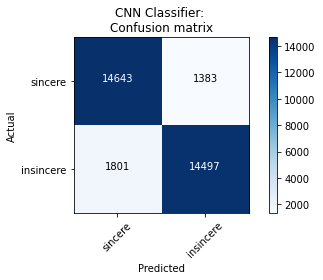

In [38]:
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['sincere', 'insincere'], 
                      title='CNN Classifier: \nConfusion matrix')

In [39]:
from sklearn.metrics import classification_report as clsr
print(clsr(labels, preds, target_names=['sincere', 'insincere']))

              precision    recall  f1-score   support

     sincere       0.89      0.91      0.90     16026
   insincere       0.91      0.89      0.90     16298

    accuracy                           0.90     32324
   macro avg       0.90      0.90      0.90     32324
weighted avg       0.90      0.90      0.90     32324



In [40]:
def predict_class(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = []
    for t in tokenized:
        if t in TEXT.vocab.stoi:
            indexed.append(TEXT.vocab.stoi[t])
        else:
            indexed.append(0)
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length).to(device)
    prediction = torch.sigmoid(model(tensor, length_tensor)).item()
    if prediction >= 0.5:
        idx = 1
    else:
        idx = 0
    label = LABEL.vocab.itos[1]
    if label == '1':
        return "{0}%".format(prediction*100)
    else:
        return "{0}%".format((1-prediction)*100)

In [41]:
predict_class(rnn, "Why cant you just die?")

'57.965898513793945%'

In [ ]:
"""cpu = torch.device('cpu')
rnn_cpu = rnn.to(cpu)
torch.save(rnn_cpu.state_dict(), 'LSTM-model-cpu.pt')"""